In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
import ShAReD_Net.model.layer.slim_heatmap_2d as heatmap_2d
import ShAReD_Net.model.layer.slim_heatmap_1d as heatmap_1d


In [3]:
def show_imgs(images, text = ""):
    plt.figure(figsize=(10,30))
    bs = images.shape[0]
    for b in range(bs):
        ks = images.shape[1]
        for k in range(ks):
            cs = images.shape[-1]
            for c in range(cs):
                ax = plt.subplot(8,2,b*ks*cs+k*cs+c+1)
                plt.imshow(images[b,k,...,c])
                plt.title(text)
                plt.axis('off')

In [4]:
from ShAReD_Net.configure import config

config.model.output.keypoints = 1
keypoints = config.model.output.keypoints

loc_prop_map_shape (4, 1, 20, 40, 1)
tf.Tensor(
[[[0.9999999 ]]

 [[0.9999999 ]]

 [[0.99999964]]

 [[0.99999976]]], shape=(4, 1, 1), dtype=float32)
LocationMap None
loc_map_shape (1, 1, 20, 40, 2)
pos tf.Tensor([390. 190.], shape=(2,), dtype=float32)
sum_loc_prob tf.Tensor(
[[[1.]]

 [[1.]]

 [[1.]]

 [[2.]]], shape=(4, 1, 1), dtype=float32)
loc: tf.Tensor(
[[[205. 105.]]

 [[205. 105.]]

 [[300.  30.]]

 [[ 25. 175.]]], shape=(4, 1, 2), dtype=float32)
gt: [[[205. 105.]]

 [[205. 105.]]

 [[300.  30.]]

 [[ 25. 175.]]]
loc: tf.Tensor(
[[[205. 105.]]

 [[205. 105.]]

 [[300.  30.]]

 [[ 50. 350.]]], shape=(4, 1, 2), dtype=float32)
gt: [[[205. 105.]]

 [[205. 105.]]

 [[300.  30.]]

 [[ 25. 175.]]]
gt_shape (4, 1, 2)
var_loss: tf.Tensor(
[[[1.9073486e-06 1.9073486e-06]]

 [[2.0000000e+02 2.0000000e+02]]

 [[0.0000000e+00 0.0000000e+00]]

 [[2.5000002e+01 2.5000002e+01]]], shape=(4, 1, 2), dtype=float32)
var_loss_shape: (4, 1, 2)
loc_loss: tf.Tensor(
[[[    0.     0.]]

 [[    0.     0.]

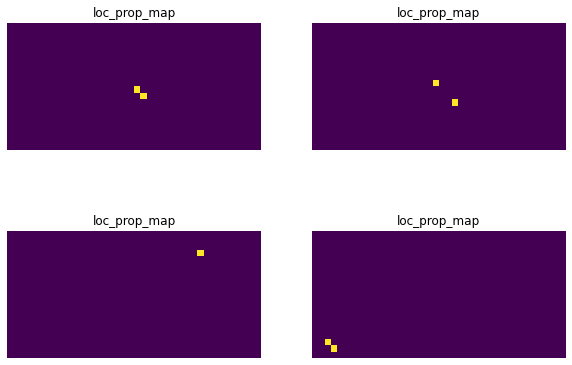

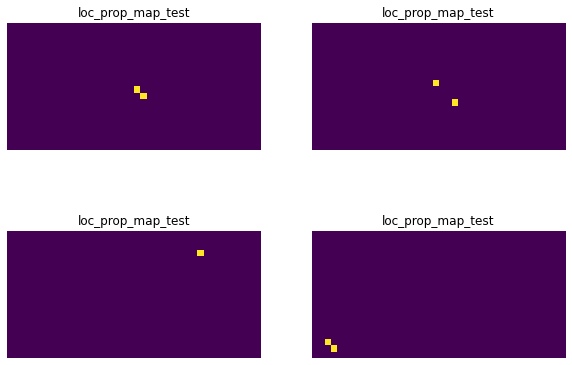

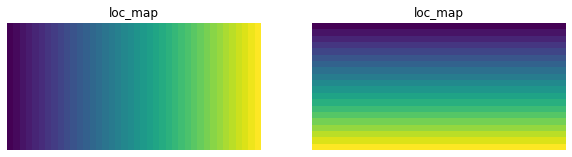

In [5]:
bins = [40,20]

loc_prop_map = np.zeros([4,bins[1],bins[0],1],dtype=np.float32)
loc_prop_map[0,10,20,0]=0.5   #x,y [20.5,10.5]
loc_prop_map[0,11,21,0]=0.5   
loc_prop_map[1,9,19,0]=0.5    #x,y [20.5,10.5]
loc_prop_map[1,12,22,0]=0.5
loc_prop_map[2,3,30,0]=1      #x,y [30,3]
loc_prop_map[3,17,2,0]=1
loc_prop_map[3,18,3,0]=1      #x,y [2.5,17.5]

gt_loc = np.asarray([[[205,105]],[[205,105]],[[300,30]],[[25,175]]],dtype=np.float32)

loc_prop_map = tf.transpose(loc_prop_map,[0,3,1,2])[...,None] #[b, k, y, x, p[]]
print("loc_prop_map_shape", loc_prop_map.shape)
show_imgs(loc_prop_map,"loc_prop_map")

ftpm = heatmap_2d.FeatureToLocationPropabilityMap()
loc_prop_map_test = ftpm(loc_prop_map)
print(tf.reduce_sum(loc_prop_map_test,axis=[2,3]))

show_imgs(loc_prop_map_test,"loc_prop_map_test")

loc_map_op = heatmap_2d.LocationMap(min_loc=[0,0], max_loc=[400,200],bins=bins)
loc_map = loc_map_op([0.,0.])
print("loc_map_shape", loc_map.shape)

show_imgs(loc_map,"loc_map")
print("pos",loc_map[0,0,19,39])  #x,y [39,19] = 390,190


sum_loc_prob = tf.reduce_sum(loc_prop_map, axis=[2,3])
loc_prop_map_test = loc_prop_map / sum_loc_prob[:,:,None,None,:]
print("sum_loc_prob",sum_loc_prob)

pmtl = heatmap_2d.PropabilityMapToLocation()
loc = pmtl([loc_prop_map_test, loc_map])
print("loc:",loc)
print("gt:",gt_loc)

assert(tf.reduce_all(loc == gt_loc))

pmtl = heatmap_2d.PropabilityMapToLocation()
loc = pmtl([loc_prop_map, loc_map])
print("loc:",loc)
print("gt:",gt_loc)

print("gt_shape",gt_loc.shape)

vll = heatmap_2d.VarianceLocatonLoss(loc_map_op.loc_delta)
loss = vll([loc_prop_map, loc_map, gt_loc])
print("var_loss:",loss)
print("var_loss_shape:",loss.shape)

vlapl = heatmap_2d.VarianceLocationAndPossitionLoss(loc_map_op.loc_delta)
loss,var = vlapl([loc, gt_loc, loc_prop_map, loc_map])
print("loc_loss:",loss)
print("loc_loss_shape:",loss.shape)

In [6]:
def show_imgs_z(images,text=""):
    plt.figure(figsize=(30,5))
    for i, img in enumerate(images):
        cs = img.shape[-1]
        for c in range(cs):
            ax = plt.subplot(2,20,i*cs+c+1)
            plt.imshow(img[...,c])
            plt.title(text)
            plt.axis('off')

tf.Tensor(
[[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.
   0.  0.  0. ]]

 [[0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  1. ]]

 [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.
   0.  0.  0. ]]], shape=(4, 1, 20), dtype=float32)
tf.Tensor(
[[[0.04695399 0.04695399 0.04695399 0.04695399 0.04695399 0.04695399
   0.04695399 0.04695399 0.04695399 0.04695399 0.07741405 0.07741405
   0.04695399 0.04695399 0.04695399 0.04695399 0.04695399 0.04695399
   0.04695399 0.04695399]]

 [[0.04695399 0.04695399 0.04695399 0.07741405 0.07741405 0.04695399
   0.04695399 0.04695399 0.04695399 0.04695399 0.04695399 0.04695399
   0.04695399 0.04695399 0.04695399 0.04695399 0.04695399 0.04695399
   0.04695399 0.04695399]]

 [[0.04604416 0.04604416 0.04604416 0.04604416 0.04604416 0.04604416
   0.04604416 0.04604416 0.04604416 0.04604416 0.0460

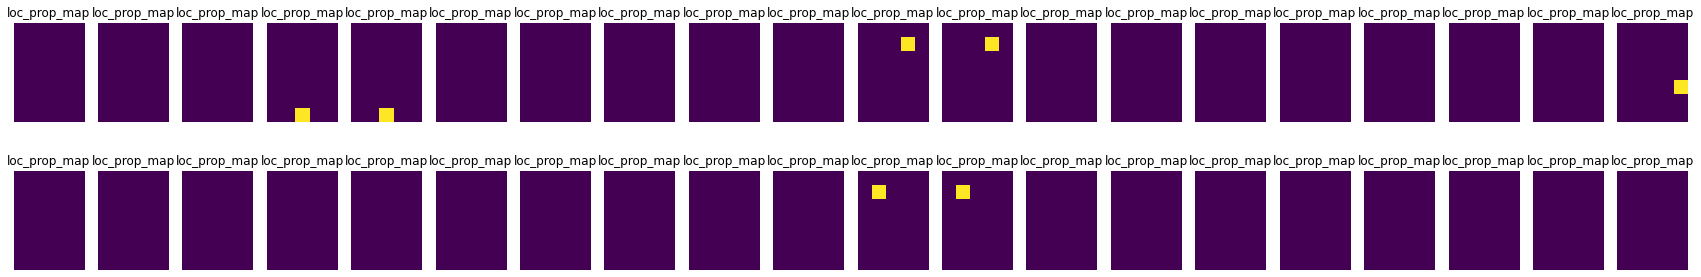

In [7]:
bins = 20
bin_half = int(bins/2)
loc_prop_map = np.zeros([2,7,5,bins],dtype=np.float32)
loc_prop_map[0,1,3,bin_half]=0.5
loc_prop_map[0,1,3,bin_half+1]=0.5
loc_prop_map[0,6,2,3]=0.5
loc_prop_map[0,6,2,4]=0.5
loc_prop_map[0,4,4,19]=1
loc_prop_map[1,1,1,bin_half]=1
loc_prop_map[1,1,1,bin_half+1]=1

gt_index = np.asarray([[0,1,3],[0,6,2],[0,4,4],[1,1,1]],dtype=np.int32)
gt_loc = np.asarray([[[31]],[[17]],[[48]],[[62]]],dtype=np.float32)

show_imgs_z(loc_prop_map,"loc_prop_map")

relevant_features = tf.gather_nd(loc_prop_map, gt_index) # [b*k, bins]
relevant_features = tf.reshape(relevant_features, [-1,keypoints,bins]) 
print(relevant_features)

ftpm = heatmap_1d.FeatureToLocationPropabilityMap()
loc_prop_map_test = ftpm(relevant_features)

print(loc_prop_map_test)

loc_map_op = heatmap_1d.LocationMap(bins=bins, min_loc=10, max_loc=50)
loc_map = loc_map_op(0.)
print(loc_map)


pmtl = heatmap_1d.PropabilityMapToLocation()
loc = pmtl([relevant_features, loc_map])
print("loc:",loc)



vll = heatmap_1d.VarianceLocatonLoss(loc_map_op.loc_delta)
loss = vll([relevant_features, loc_map, gt_loc])
print("var_loss:",loss)

vlapl = heatmap_1d.VarianceLocationAndPossitionLoss(loc_map_op.loc_delta)
loss = vlapl([loc, gt_loc, relevant_features, loc_map])
print("loc_loss:",loss)
